# Notebook 03: Comprehensive Feature Extraction

**Project:** EEG Signal Analysis for MDD Detection  
**Sprint 3:** Feature Extraction  
**Objective:** Extract 150+ features from cleaned EEG signals

---

## 📋 Pipeline Overview

1. **Load Cleaned Signals** (Wavelet method, 55 subjects)
2. **Segmentation** (2-second windows, 50% overlap)
3. **Time-Domain Features** (30 features)
4. **Frequency-Domain Features** (50 features)
5. **Time-Frequency Features** (40 features)
6. **Non-Linear Features** (30 features)
7. **Feature Selection** (reduce to 30-50 features)
8. **Feature Validation** (statistical tests, visualization)
9. **Save Feature Matrix**

---

**Expected Runtime:** 3-4 hours (55 subjects × ~16,000 segments)

## 1. Setup & Configuration

In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from pathlib import Path
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Signal processing
from scipy import signal
from scipy import stats
import pywt

# Non-linear features
import antropy as ant
import nolds
try:
    import EntropyHub as eh
    ENTROPYHUB_AVAILABLE = True
except ImportError:
    ENTROPYHUB_AVAILABLE = False
    print("⚠️ EntropyHub not available, some entropy features will be skipped")

# Feature selection
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, f_classif
from sklearn.preprocessing import StandardScaler

# Parallel processing
from joblib import Parallel, delayed
import multiprocessing

# Visualization
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully")
print(f"Available CPU cores: {multiprocessing.cpu_count()}")

✅ All libraries imported successfully
Available CPU cores: 10


In [2]:
# Load configuration
with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Project paths
PROJECT_ROOT = Path('../')
CLEANED_SIGNALS_DIR = PROJECT_ROOT / 'data' / 'processed' / 'cleaned_signals'
FEATURES_DIR = PROJECT_ROOT / 'data' / 'features'
FIGURES_DIR = PROJECT_ROOT / 'results' / 'figures' / 'features'
TABLES_DIR = PROJECT_ROOT / 'results' / 'tables'

# Create directories
for dir_path in [FEATURES_DIR, FIGURES_DIR, TABLES_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

# EEG parameters
SAMPLING_RATE = config['data']['sampling_rate']
TARGET_CHANNEL = 'T4'  # ← Direct assignment (we already know it's T4)

# Segmentation parameters
SEGMENT_DURATION = 2.0  # seconds
OVERLAP = 0.5  # 50%
SEGMENT_LENGTH = int(SEGMENT_DURATION * SAMPLING_RATE)  # 512 samples
STRIDE = int(SEGMENT_LENGTH * (1 - OVERLAP))  # 256 samples

# Frequency bands (Hz)
BANDS = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'gamma': (30, 45)
}

# Feature selection parameters
VARIANCE_THRESHOLD = 0.01  # 1%
CORRELATION_THRESHOLD = 0.95
TOP_K_FEATURES = 50

print(f"\n📁 Project Root: {PROJECT_ROOT}")
print(f"📊 Cleaned signals: {CLEANED_SIGNALS_DIR}")
print(f"⚙️  Sampling Rate: {SAMPLING_RATE} Hz")
print(f"🎯 Target Channel: {TARGET_CHANNEL}")
print(f"📏 Segment: {SEGMENT_DURATION}s ({SEGMENT_LENGTH} samples), Overlap: {OVERLAP*100}%")
print(f"🔢 Stride: {STRIDE} samples ({STRIDE/SAMPLING_RATE:.2f}s)")
print(f"🎵 Frequency bands: {list(BANDS.keys())}")



📁 Project Root: ..
📊 Cleaned signals: ../data/processed/cleaned_signals
⚙️  Sampling Rate: 256 Hz
🎯 Target Channel: T4
📏 Segment: 2.0s (512 samples), Overlap: 50.0%
🔢 Stride: 256 samples (1.00s)
🎵 Frequency bands: ['delta', 'theta', 'alpha', 'beta', 'gamma']


## 2. Load Cleaned Signals

In [3]:
# Load metadata
metadata = pd.read_csv(PROJECT_ROOT / 'data' / 'processed' / 'cleaned_signals_metadata.csv')
print(f"📊 Loaded metadata: {len(metadata)} subjects")
print(f"   - Healthy: {len(metadata[metadata['group']=='Healthy'])}")
print(f"   - MDD: {len(metadata[metadata['group']=='MDD'])}")
print(f"\n📈 Statistics:")
print(metadata.groupby('group')[['snr', 'rms', 'duration']].describe())

📊 Loaded metadata: 55 subjects
   - Healthy: 25
   - MDD: 30

📈 Statistics:
          snr                                                                  \
        count       mean       std       min        25%        50%        75%   
group                                                                           
Healthy  25.0  11.911855  2.898048  5.360532  10.952135  11.839104  13.850870   
MDD      30.0  10.444031  3.256332  6.035578   8.748010   9.737293  10.976362   

                     rms             ...                       duration  \
               max count       mean  ...        75%        max    count   
group                                ...                                  
Healthy  18.154036  25.0  11.638510  ...   8.162452  86.496059     25.0   
MDD      19.190745  30.0  15.220997  ...  17.425793  92.628837     30.0   

                                                               
           mean        std    min    25%    50%    75%    max  
group         

In [4]:
# Function to load single cleaned signal
def load_cleaned_signal(file_path):
    """Load cleaned signal from .npy file"""
    try:
        signal_data = np.load(file_path)
        return signal_data
    except Exception as e:
        print(f"❌ Error loading {file_path.name}: {e}")
        return None

# Test load
test_file = CLEANED_SIGNALS_DIR / metadata.iloc[0]['cleaned_file']
test_signal = load_cleaned_signal(test_file)
print(f"\n✅ Test signal loaded: {test_file.name}")
print(f"   Shape: {test_signal.shape}")
print(f"   Duration: {len(test_signal) / SAMPLING_RATE:.2f} seconds")
print(f"   Expected segments: {(len(test_signal) - SEGMENT_LENGTH) // STRIDE + 1}")


✅ Test signal loaded: S1_Healthy_T4_cleaned.npy
   Shape: (76800,)
   Duration: 300.00 seconds
   Expected segments: 299


## 3. Signal Segmentation

In [5]:
def segment_signal(signal_data, segment_length=SEGMENT_LENGTH, stride=STRIDE):
    """
    Segment signal into overlapping windows
    
    Parameters:
    -----------
    signal_data : np.ndarray
        1D signal array
    segment_length : int
        Length of each segment (samples)
    stride : int
        Step size between segments (samples)
        
    Returns:
    --------
    segments : np.ndarray
        2D array (n_segments, segment_length)
    """
    n_samples = len(signal_data)
    segments = []
    
    for start in range(0, n_samples - segment_length + 1, stride):
        segment = signal_data[start:start + segment_length]
        segments.append(segment)
    
    return np.array(segments)

# Test segmentation
test_segments = segment_signal(test_signal)
print(f"✅ Segmentation test:")
print(f"   Input: {test_signal.shape}")
print(f"   Output: {test_segments.shape} (n_segments, segment_length)")
print(f"   Segment duration: {SEGMENT_LENGTH / SAMPLING_RATE} seconds")
print(f"   Overlap: {OVERLAP * 100}%")

✅ Segmentation test:
   Input: (76800,)
   Output: (299, 512) (n_segments, segment_length)
   Segment duration: 2.0 seconds
   Overlap: 50.0%


## 4. Time-Domain Features

Extract 30 statistical and temporal features

In [6]:
def extract_time_domain_features(segment):
    """
    Extract time-domain features from a signal segment
    
    Returns 30 features:
    - Statistical: mean, median, std, var, skew, kurtosis, iqr, mad
    - Amplitude: min, max, peak-to-peak, rms, energy
    - Temporal: zero-crossing rate, mean crossing rate
    - Hjorth: activity, mobility, complexity
    - Percentiles: 25th, 75th, 90th
    - Derivatives: mean/std of 1st and 2nd derivatives
    - Line length, total variation
    """
    features = {}
    
    # Statistical features
    features['time_mean'] = np.mean(segment)
    features['time_median'] = np.median(segment)
    features['time_std'] = np.std(segment)
    features['time_var'] = np.var(segment)
    features['time_skew'] = stats.skew(segment)
    features['time_kurtosis'] = stats.kurtosis(segment)
    features['time_iqr'] = np.percentile(segment, 75) - np.percentile(segment, 25)
    features['time_mad'] = np.median(np.abs(segment - np.median(segment)))
    
    # Amplitude features
    features['time_min'] = np.min(segment)
    features['time_max'] = np.max(segment)
    features['time_ptp'] = np.ptp(segment)  # peak-to-peak
    features['time_rms'] = np.sqrt(np.mean(segment**2))
    features['time_energy'] = np.sum(segment**2)
    
    # Temporal features
    # Zero-crossing rate
    zero_crossings = np.where(np.diff(np.sign(segment)))[0]
    features['time_zcr'] = len(zero_crossings) / len(segment)
    
    # Mean crossing rate
    mean_val = np.mean(segment)
    mean_crossings = np.where(np.diff(np.sign(segment - mean_val)))[0]
    features['time_mcr'] = len(mean_crossings) / len(segment)
    
    # Hjorth parameters
    # Activity (variance)
    features['hjorth_activity'] = np.var(segment)
    
    # Mobility (sqrt of variance of first derivative / variance)
    diff1 = np.diff(segment)
    features['hjorth_mobility'] = np.sqrt(np.var(diff1) / np.var(segment))
    
    # Complexity (mobility of first derivative / mobility of signal)
    diff2 = np.diff(diff1)
    mobility_diff1 = np.sqrt(np.var(diff2) / np.var(diff1))
    features['hjorth_complexity'] = mobility_diff1 / features['hjorth_mobility']
    
    # Percentiles
    features['time_p25'] = np.percentile(segment, 25)
    features['time_p75'] = np.percentile(segment, 75)
    features['time_p90'] = np.percentile(segment, 90)
    
    # Derivative features
    features['time_diff1_mean'] = np.mean(np.abs(diff1))
    features['time_diff1_std'] = np.std(diff1)
    features['time_diff2_mean'] = np.mean(np.abs(diff2))
    features['time_diff2_std'] = np.std(diff2)
    
    # Line length (sum of absolute differences)
    features['time_line_length'] = np.sum(np.abs(diff1))
    
    # Total variation
    features['time_total_variation'] = np.sum(np.abs(diff1)) / len(segment)
    
    # Coefficient of variation
    features['time_cv'] = features['time_std'] / (np.abs(features['time_mean']) + 1e-10)
    
    # Range normalized by std
    features['time_range_norm'] = features['time_ptp'] / (features['time_std'] + 1e-10)
    
    return features

# Test time-domain features
test_td_features = extract_time_domain_features(test_segments[0])
print(f"✅ Time-domain features extracted: {len(test_td_features)} features")
print(f"\nSample features:")
for key, val in list(test_td_features.items())[:5]:
    print(f"   {key}: {val:.4f}")

✅ Time-domain features extracted: 29 features

Sample features:
   time_mean: 0.9530
   time_median: 1.0591
   time_std: 5.3309
   time_var: 28.4186
   time_skew: -0.0599


## 5. Frequency-Domain Features

Extract 50 spectral features including band powers

In [7]:
def extract_frequency_domain_features(segment, fs=SAMPLING_RATE, bands=BANDS):
    """
    Extract frequency-domain features from a signal segment
    
    Returns 50 features:
    - Band powers (5 bands × 4 metrics): absolute, relative, log, normalized
    - Band ratios: theta/alpha, (theta+alpha)/beta, etc.
    - Spectral: centroid, spread, entropy, edge, slope, flatness
    - Peak: dominant frequency, peak power, peak width
    - PSD statistics: mean, std, skew, kurtosis
    """
    features = {}
    
    # Compute Power Spectral Density using Welch method
    freqs, psd = signal.welch(segment, fs=fs, nperseg=min(256, len(segment)))
    
    # Total power
    total_power = np.trapz(psd, freqs)
    
    # Band powers (absolute, relative, log, normalized)
    band_powers = {}
    for band_name, (low, high) in bands.items():
        idx = np.where((freqs >= low) & (freqs <= high))[0]
        if len(idx) > 0:
            band_power = np.trapz(psd[idx], freqs[idx])
            band_powers[band_name] = band_power
            
            # Absolute power
            features[f'freq_{band_name}_power_abs'] = band_power
            
            # Relative power (percentage of total)
            features[f'freq_{band_name}_power_rel'] = band_power / (total_power + 1e-10)
            
            # Log power
            features[f'freq_{band_name}_power_log'] = np.log10(band_power + 1e-10)
            
            # Normalized (z-score within segment)
            features[f'freq_{band_name}_power_norm'] = (band_power - np.mean(psd)) / (np.std(psd) + 1e-10)
        else:
            # If band not found, set to 0
            features[f'freq_{band_name}_power_abs'] = 0
            features[f'freq_{band_name}_power_rel'] = 0
            features[f'freq_{band_name}_power_log'] = -10
            features[f'freq_{band_name}_power_norm'] = 0
            band_powers[band_name] = 0
    
    # Band ratios (important for EEG analysis)
    features['freq_theta_alpha_ratio'] = band_powers['theta'] / (band_powers['alpha'] + 1e-10)
    features['freq_theta_beta_ratio'] = band_powers['theta'] / (band_powers['beta'] + 1e-10)
    features['freq_alpha_beta_ratio'] = band_powers['alpha'] / (band_powers['beta'] + 1e-10)
    features['freq_delta_alpha_ratio'] = band_powers['delta'] / (band_powers['alpha'] + 1e-10)
    features['freq_low_high_ratio'] = (band_powers['delta'] + band_powers['theta']) / \
                                       (band_powers['alpha'] + band_powers['beta'] + 1e-10)
    
    # Spectral centroid (center of mass of spectrum)
    features['freq_spectral_centroid'] = np.sum(freqs * psd) / (np.sum(psd) + 1e-10)
    
    # Spectral spread (standard deviation around centroid)
    features['freq_spectral_spread'] = np.sqrt(np.sum(((freqs - features['freq_spectral_centroid'])**2) * psd) / 
                                                (np.sum(psd) + 1e-10))
    
    # Spectral entropy
    psd_norm = psd / (np.sum(psd) + 1e-10)
    features['freq_spectral_entropy'] = -np.sum(psd_norm * np.log2(psd_norm + 1e-10))
    
    # Spectral edge frequency (95% of power)
    cumsum_psd = np.cumsum(psd)
    idx_95 = np.where(cumsum_psd >= 0.95 * cumsum_psd[-1])[0]
    features['freq_spectral_edge'] = freqs[idx_95[0]] if len(idx_95) > 0 else freqs[-1]
    
    # Spectral slope (linear fit to log-log spectrum)
    log_freqs = np.log10(freqs[1:] + 1e-10)  # Avoid log(0)
    log_psd = np.log10(psd[1:] + 1e-10)
    slope, intercept = np.polyfit(log_freqs, log_psd, 1)
    features['freq_spectral_slope'] = slope
    
    # Spectral flatness (Wiener entropy)
    geometric_mean = np.exp(np.mean(np.log(psd + 1e-10)))
    arithmetic_mean = np.mean(psd)
    features['freq_spectral_flatness'] = geometric_mean / (arithmetic_mean + 1e-10)
    
    # Dominant frequency (peak)
    peak_idx = np.argmax(psd)
    features['freq_dominant_freq'] = freqs[peak_idx]
    features['freq_peak_power'] = psd[peak_idx]
    
    # Peak width (FWHM - Full Width at Half Maximum)
    half_max = psd[peak_idx] / 2
    above_half_max = psd > half_max
    features['freq_peak_width'] = np.sum(above_half_max) * (freqs[1] - freqs[0])
    
    # PSD statistics
    features['freq_psd_mean'] = np.mean(psd)
    features['freq_psd_std'] = np.std(psd)
    features['freq_psd_skew'] = stats.skew(psd)
    features['freq_psd_kurtosis'] = stats.kurtosis(psd)
    
    return features

# Test frequency-domain features
test_fd_features = extract_frequency_domain_features(test_segments[0])
print(f"✅ Frequency-domain features extracted: {len(test_fd_features)} features")
print(f"\nSample features:")
for key, val in list(test_fd_features.items())[:5]:
    print(f"   {key}: {val:.4f}")

✅ Frequency-domain features extracted: 38 features

Sample features:
   freq_delta_power_abs: 6.9592
   freq_delta_power_rel: 0.2793
   freq_delta_power_log: 0.8426
   freq_delta_power_norm: 12.2137
   freq_theta_power_abs: 2.3521


## 6. Time-Frequency Features

Extract 40 wavelet-based features

In [8]:
def extract_time_frequency_features(segment, wavelet='db4', level=5):
    """
    Extract time-frequency features using Wavelet Transform
    
    Returns 40 features:
    - Wavelet coefficients (5 levels × 8 features): energy, mean, std, entropy, max, min, range, norm
    """
    features = {}
    
    # Discrete Wavelet Transform
    coeffs = pywt.wavedec(segment, wavelet, level=level)
    
    # Process each level
    for i, coeff in enumerate(coeffs):
        level_name = f'cA{level}' if i == 0 else f'cD{level - i + 1}'
        
        # Energy (sum of squared coefficients)
        features[f'tf_{level_name}_energy'] = np.sum(coeff**2)
        
        # Mean
        features[f'tf_{level_name}_mean'] = np.mean(np.abs(coeff))
        
        # Standard deviation
        features[f'tf_{level_name}_std'] = np.std(coeff)
        
        # Entropy
        coeff_norm = np.abs(coeff) / (np.sum(np.abs(coeff)) + 1e-10)
        features[f'tf_{level_name}_entropy'] = -np.sum(coeff_norm * np.log2(coeff_norm + 1e-10))
        
        # Max, Min, Range
        features[f'tf_{level_name}_max'] = np.max(np.abs(coeff))
        features[f'tf_{level_name}_min'] = np.min(np.abs(coeff))
        features[f'tf_{level_name}_range'] = features[f'tf_{level_name}_max'] - features[f'tf_{level_name}_min']
        
        # L2 norm
        features[f'tf_{level_name}_norm'] = np.linalg.norm(coeff)
    
    return features

# Test time-frequency features
test_tf_features = extract_time_frequency_features(test_segments[0])
print(f"✅ Time-frequency features extracted: {len(test_tf_features)} features")
print(f"\nSample features:")
for key, val in list(test_tf_features.items())[:5]:
    print(f"   {key}: {val:.4f}")

✅ Time-frequency features extracted: 48 features

Sample features:
   tf_cA5_energy: 13862.9153
   tf_cA5_mean: 22.0209
   tf_cA5_std: 23.4365
   tf_cA5_entropy: 4.2145
   tf_cA5_max: 51.8443


## 7. Non-Linear Features

Extract 30 complexity and entropy features

In [9]:
def extract_nonlinear_features(segment, fs=SAMPLING_RATE):
    """
    Extract non-linear features from a signal segment
    
    Returns 30 features:
    - Entropy: Sample, Approximate, Spectral, Permutation, SVD, Multiscale
    - Fractal: Higuchi FD, Petrosian FD, Katz FD
    - Complexity: Lempel-Ziv, DFA (alpha), Hurst exponent
    - Lyapunov exponent
    - Statistical complexity measures
    """
    features = {}
    
    # ===== ENTROPY MEASURES =====
    
    # Sample Entropy (antropy)
    try:
        features['nl_sample_entropy'] = ant.sample_entropy(segment, order=2)
    except:
        features['nl_sample_entropy'] = 0
    
    # Approximate Entropy (antropy)
    try:
        features['nl_approx_entropy'] = ant.app_entropy(segment, order=2)
    except:
        features['nl_approx_entropy'] = 0
    
    # Spectral Entropy (antropy)
    try:
        features['nl_spectral_entropy'] = ant.spectral_entropy(segment, sf=fs, method='welch')
    except:
        features['nl_spectral_entropy'] = 0
    
    # Permutation Entropy (antropy)
    try:
        features['nl_perm_entropy'] = ant.perm_entropy(segment, order=3, normalize=True)
    except:
        features['nl_perm_entropy'] = 0
    
    # SVD Entropy (antropy)
    try:
        features['nl_svd_entropy'] = ant.svd_entropy(segment, order=3, delay=1, normalize=True)
    except:
        features['nl_svd_entropy'] = 0
    
    # Multiscale Entropy (antropy) - slow, use shorter segment
    try:
        mse = ant.multiscale_entropy(segment[:256], maxscale=3)
        features['nl_multiscale_entropy_mean'] = np.mean(mse)
        features['nl_multiscale_entropy_std'] = np.std(mse)
    except:
        features['nl_multiscale_entropy_mean'] = 0
        features['nl_multiscale_entropy_std'] = 0
    
    # ===== FRACTAL DIMENSION =====
    
    # Higuchi Fractal Dimension (antropy)
    try:
        features['nl_higuchi_fd'] = ant.higuchi_fd(segment, kmax=10)
    except:
        features['nl_higuchi_fd'] = 0
    
    # Petrosian Fractal Dimension (antropy)
    try:
        features['nl_petrosian_fd'] = ant.petrosian_fd(segment)
    except:
        features['nl_petrosian_fd'] = 0
    
    # Katz Fractal Dimension (antropy)
    try:
        features['nl_katz_fd'] = ant.katz_fd(segment)
    except:
        features['nl_katz_fd'] = 0
    
    # ===== COMPLEXITY MEASURES =====
    
    # Lempel-Ziv Complexity (antropy)
    try:
        features['nl_lzc'] = ant.lziv_complexity(segment > np.median(segment), normalize=True)
    except:
        features['nl_lzc'] = 0
    
    # Detrended Fluctuation Analysis (nolds)
    try:
        features['nl_dfa'] = nolds.dfa(segment)
    except:
        features['nl_dfa'] = 0
    
    # Hurst Exponent (nolds)
    try:
        features['nl_hurst'] = nolds.hurst_rs(segment)
    except:
        features['nl_hurst'] = 0
    
    # Lyapunov Exponent (nolds)
    try:
        features['nl_lyapunov'] = nolds.lyap_r(segment, emb_dim=10, lag=1, min_tsep=1)
    except:
        features['nl_lyapunov'] = 0
    
    # Correlation Dimension (nolds)
    try:
        features['nl_corr_dim'] = nolds.corr_dim(segment, emb_dim=10)
    except:
        features['nl_corr_dim'] = 0
    
    # ===== ADDITIONAL STATISTICAL COMPLEXITY =====
    
    # Coefficient of Variation of successive differences
    diff = np.diff(segment)
    features['nl_cv_diff'] = np.std(diff) / (np.abs(np.mean(diff)) + 1e-10)
    
    # Root Mean Square of successive differences (RMSSD)
    features['nl_rmssd'] = np.sqrt(np.mean(diff**2))
    
    # Median Absolute Deviation of differences
    features['nl_mad_diff'] = np.median(np.abs(diff - np.median(diff)))
    
    # Number of peaks
    from scipy.signal import find_peaks
    peaks, _ = find_peaks(segment)
    features['nl_n_peaks'] = len(peaks) / len(segment)
    
    # Peak prominence mean
    if len(peaks) > 0:
        prominences, _, _ = signal.peak_prominences(segment, peaks)
        features['nl_peak_prominence_mean'] = np.mean(prominences)
        features['nl_peak_prominence_std'] = np.std(prominences)
    else:
        features['nl_peak_prominence_mean'] = 0
        features['nl_peak_prominence_std'] = 0
    
    # Turning points
    diff_sign = np.diff(np.sign(diff))
    features['nl_turning_points'] = np.sum(diff_sign != 0) / len(segment)
    
    # Mean absolute deviation from median
    features['nl_mad_from_median'] = np.mean(np.abs(segment - np.median(segment)))
    
    # Interquartile coefficient of dispersion
    q75, q25 = np.percentile(segment, [75, 25])
    features['nl_iqr_coef'] = (q75 - q25) / (q75 + q25 + 1e-10)
    
    # Quartile coefficient of variation
    features['nl_qcv'] = (q75 - q25) / (np.median(segment) + 1e-10)
    
    # Dispersion ratio (std to range)
    features['nl_dispersion_ratio'] = np.std(segment) / (np.ptp(segment) + 1e-10)
    
    # Mean absolute change
    features['nl_mean_abs_change'] = np.mean(np.abs(diff))
    
    # Mean change
    features['nl_mean_change'] = np.mean(diff)
    
    return features

# Test non-linear features
test_nl_features = extract_nonlinear_features(test_segments[0])
print(f"✅ Non-linear features extracted: {len(test_nl_features)} features")
print(f"\nSample features:")
for key, val in list(test_nl_features.items())[:5]:
    print(f"   {key}: {val:.4f}")

✅ Non-linear features extracted: 28 features

Sample features:
   nl_sample_entropy: 0.8468
   nl_approx_entropy: 0.8414
   nl_spectral_entropy: 4.6427
   nl_perm_entropy: 0.7648
   nl_svd_entropy: 0.6428


## 8. Combined Feature Extraction Function

In [10]:
def extract_all_features(segment, fs=SAMPLING_RATE):
    """
    Extract all features from a single segment
    
    Returns:
    --------
    features : dict
        Dictionary with ~150 features
    """
    features = {}
    
    # Time-domain
    features.update(extract_time_domain_features(segment))
    
    # Frequency-domain
    features.update(extract_frequency_domain_features(segment, fs=fs))
    
    # Time-frequency
    features.update(extract_time_frequency_features(segment))
    
    # Non-linear
    features.update(extract_nonlinear_features(segment, fs=fs))
    
    return features

# Test combined extraction
test_all_features = extract_all_features(test_segments[0])
print(f"✅ Total features extracted: {len(test_all_features)} features")
print(f"\n📊 Feature breakdown:")
print(f"   - Time-domain: {len([k for k in test_all_features.keys() if k.startswith('time_') or k.startswith('hjorth_')])}")
print(f"   - Frequency-domain: {len([k for k in test_all_features.keys() if k.startswith('freq_')])}")
print(f"   - Time-frequency: {len([k for k in test_all_features.keys() if k.startswith('tf_')])}")
print(f"   - Non-linear: {len([k for k in test_all_features.keys() if k.startswith('nl_')])}")

✅ Total features extracted: 143 features

📊 Feature breakdown:
   - Time-domain: 29
   - Frequency-domain: 38
   - Time-frequency: 48
   - Non-linear: 28


## 9. Batch Feature Extraction - All Subjects

In [11]:
def process_single_subject(subject_info):
    """
    Process single subject: load signal, segment, extract features
    
    Parameters:
    -----------
    subject_info : dict
        Dictionary with subject metadata
        
    Returns:
    --------
    features_df : pd.DataFrame
        Feature matrix for all segments of this subject
    """
    subject_id = subject_info['subject_id']
    group = subject_info['group']
    file_path = CLEANED_SIGNALS_DIR / subject_info['cleaned_file']
    
    try:
        # Load signal
        signal_data = load_cleaned_signal(file_path)
        if signal_data is None:
            return None
        
        # Segment signal
        segments = segment_signal(signal_data)
        
        # Extract features for each segment
        segment_features = []
        for seg_idx, segment in enumerate(segments):
            features = extract_all_features(segment)
            
            # Add metadata
            features['subject_id'] = subject_id
            features['group'] = group
            features['segment_idx'] = seg_idx
            
            segment_features.append(features)
        
        # Convert to DataFrame
        features_df = pd.DataFrame(segment_features)
        
        return features_df
        
    except Exception as e:
        print(f"❌ Error processing {subject_id}: {e}")
        return None

print("✅ Subject processing function ready")

✅ Subject processing function ready


In [13]:
# Process all subjects with parallel processing
print("🚀 Starting batch feature extraction for 55 subjects...")
print(f"   Estimated segments: ~16,000")
print(f"   Estimated time: 3-4 hours\n")

# Prepare subject list
subject_list = metadata.to_dict('records')

# Number of cores
n_cores = max(1, multiprocessing.cpu_count() - 2)

# Parallel processing
all_features = Parallel(n_jobs=n_cores, verbose=10)(
    delayed(process_single_subject)(subject_info)
    for subject_info in subject_list
)

# Filter out None results
all_features = [df for df in all_features if df is not None]

# Concatenate all features
features_df = pd.concat(all_features, ignore_index=True)

print("\n" + "="*80)
print("🎉 FEATURE EXTRACTION COMPLETED")
print("="*80)
print(f"Total segments: {len(features_df)}")
print(f"Total features: {len(features_df.columns) - 3}")  # Exclude metadata columns
print(f"Healthy segments: {len(features_df[features_df['group']=='Healthy'])}")
print(f"MDD segments: {len(features_df[features_df['group']=='MDD'])}")
print("="*80)

🚀 Starting batch feature extraction for 55 subjects...
   Estimated segments: ~16,000
   Estimated time: 3-4 hours



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


/Users/rzkynovan/datsci/fp_pcs/venv/lib/python3.10/site-packages/nolds/datasets.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/rzkynovan/datsci/fp_pcs/venv/lib/python3.10/site-packages/nolds/datasets.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/rzkynovan/datsci/fp_pcs/venv/lib/python3.10/site-packages/nolds/datasets.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this pac


🎉 FEATURE EXTRACTION COMPLETED
Total segments: 16336
Total features: 143
Healthy segments: 7546
MDD segments: 8790


[Parallel(n_jobs=8)]: Done  55 out of  55 | elapsed:  3.5min finished


In [14]:
# Check for missing values
print("\n🔍 Checking data quality...")
print(f"\nMissing values per feature (top 10):")
missing_counts = features_df.isnull().sum().sort_values(ascending=False)
print(missing_counts[missing_counts > 0].head(10))

# Check for infinite values
inf_counts = np.isinf(features_df.select_dtypes(include=[np.number])).sum().sort_values(ascending=False)
print(f"\nInfinite values per feature (top 10):")
print(inf_counts[inf_counts > 0].head(10))

# Replace inf with NaN, then fill NaN with 0
features_df.replace([np.inf, -np.inf], np.nan, inplace=True)
features_df.fillna(0, inplace=True)

print("\n✅ Data quality check complete")
print(f"   Missing values handled: {features_df.isnull().sum().sum()}")
print(f"   Infinite values handled: {np.isinf(features_df.select_dtypes(include=[np.number])).sum().sum()}")


🔍 Checking data quality...

Missing values per feature (top 10):
Series([], dtype: int64)

Infinite values per feature (top 10):
Series([], dtype: int64)

✅ Data quality check complete
   Missing values handled: 0
   Infinite values handled: 0


## 10. Feature Selection

In [15]:
# Separate features and labels
feature_columns = [col for col in features_df.columns if col not in ['subject_id', 'group', 'segment_idx']]
X = features_df[feature_columns].values
y = (features_df['group'] == 'MDD').astype(int).values  # 0=Healthy, 1=MDD

print(f"\n📊 Feature matrix shape: {X.shape}")
print(f"   Segments: {X.shape[0]}")
print(f"   Features: {X.shape[1]}")
print(f"   Class distribution: Healthy={np.sum(y==0)}, MDD={np.sum(y==1)}")


📊 Feature matrix shape: (16336, 143)
   Segments: 16336
   Features: 143
   Class distribution: Healthy=7546, MDD=8790


In [16]:
# 1. Variance Threshold
print("\n1️⃣ Variance Threshold Filtering...")
selector_var = VarianceThreshold(threshold=VARIANCE_THRESHOLD)
X_var = selector_var.fit_transform(X)
selected_var = selector_var.get_support()
features_after_var = [feature_columns[i] for i in range(len(feature_columns)) if selected_var[i]]

print(f"   Features removed: {len(feature_columns) - len(features_after_var)}")
print(f"   Features remaining: {len(features_after_var)}")


1️⃣ Variance Threshold Filtering...
   Features removed: 19
   Features remaining: 124


In [17]:
# 2. Correlation Threshold
print("\n2️⃣ Correlation Threshold Filtering...")
corr_matrix = np.corrcoef(X_var.T)
upper_tri = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
to_remove = set()

for i in range(len(corr_matrix)):
    for j in range(i+1, len(corr_matrix)):
        if abs(corr_matrix[i, j]) > CORRELATION_THRESHOLD:
            to_remove.add(j)

features_after_corr = [features_after_var[i] for i in range(len(features_after_var)) if i not in to_remove]
keep_indices = [i for i in range(len(features_after_var)) if i not in to_remove]
X_corr = X_var[:, keep_indices]

print(f"   Features removed: {len(to_remove)}")
print(f"   Features remaining: {len(features_after_corr)}")


2️⃣ Correlation Threshold Filtering...
   Features removed: 54
   Features remaining: 70


In [18]:
# 3. Statistical Tests (ANOVA F-score)
print("\n3️⃣ Statistical Significance Testing (ANOVA F-score)...")
f_scores, p_values = f_classif(X_corr, y)
f_score_df = pd.DataFrame({
    'feature': features_after_corr,
    'f_score': f_scores,
    'p_value': p_values
}).sort_values('f_score', ascending=False)

print(f"\nTop 10 features by F-score:")
print(f_score_df.head(10).to_string(index=False))


3️⃣ Statistical Significance Testing (ANOVA F-score)...

Top 10 features by F-score:
              feature     f_score  p_value
  freq_beta_power_rel 4094.502924      0.0
 freq_theta_power_rel 4090.242547      0.0
    hjorth_complexity 3531.445870      0.0
       tf_cD2_entropy 3519.334818      0.0
  freq_beta_power_log 2928.077817      0.0
       tf_cD3_entropy 2857.277938      0.0
               nl_lzc 2702.288961      0.0
               nl_dfa 2607.963768      0.0
freq_theta_power_norm 2572.991039      0.0
freq_spectral_entropy 2418.482838      0.0


In [19]:
# 4. Mutual Information
print("\n4️⃣ Mutual Information Analysis...")
mi_scores = mutual_info_classif(X_corr, y, random_state=42)
mi_df = pd.DataFrame({
    'feature': features_after_corr,
    'mi_score': mi_scores
}).sort_values('mi_score', ascending=False)

print(f"\nTop 10 features by Mutual Information:")
print(mi_df.head(10).to_string(index=False))


4️⃣ Mutual Information Analysis...

Top 10 features by Mutual Information:
              feature  mi_score
    hjorth_complexity  0.198506
freq_theta_beta_ratio  0.178911
  freq_beta_power_rel  0.177924
       tf_cD3_entropy  0.175663
   freq_dominant_freq  0.168653
               nl_dfa  0.155719
             time_min  0.153297
      hjorth_mobility  0.148299
       tf_cD2_entropy  0.146627
  freq_beta_power_log  0.140494


In [20]:
# 5. Select Top K Features (combined score)
print(f"\n5️⃣ Selecting Top {TOP_K_FEATURES} Features...")

# Normalize scores
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
f_scores_norm = scaler.fit_transform(f_scores.reshape(-1, 1)).flatten()
mi_scores_norm = scaler.fit_transform(mi_scores.reshape(-1, 1)).flatten()

# Combined score (50% F-score + 50% MI)
combined_scores = 0.5 * f_scores_norm + 0.5 * mi_scores_norm

# Select top K
top_k_indices = np.argsort(combined_scores)[-TOP_K_FEATURES:]
selected_features = [features_after_corr[i] for i in top_k_indices]
X_selected = X_corr[:, top_k_indices]

# Create final feature importance DataFrame
feature_importance = pd.DataFrame({
    'feature': [features_after_corr[i] for i in top_k_indices],
    'f_score': f_scores[top_k_indices],
    'mi_score': mi_scores[top_k_indices],
    'combined_score': combined_scores[top_k_indices]
}).sort_values('combined_score', ascending=False)

print(f"\n✅ Selected {len(selected_features)} features")
print(f"\nTop 20 features:")
print(feature_importance.head(20).to_string(index=False))


5️⃣ Selecting Top 50 Features...

✅ Selected 50 features

Top 20 features:
               feature     f_score  mi_score  combined_score
   freq_beta_power_rel 4094.502924  0.177924        0.945681
     hjorth_complexity 3531.445870  0.198506        0.931242
  freq_theta_power_rel 4090.242547  0.134962        0.831786
        tf_cD2_entropy 3519.334818  0.146627        0.792854
        tf_cD3_entropy 2857.277938  0.175663        0.788633
 freq_theta_beta_ratio 2346.741544  0.178911        0.734859
                nl_dfa 2607.963768  0.155719        0.705555
   freq_beta_power_log 2928.077817  0.140494        0.704467
                nl_lzc 2702.288961  0.120954        0.625328
       hjorth_mobility 1886.049804  0.148299        0.597818
 freq_spectral_entropy 2418.482838  0.123167        0.596512
freq_theta_alpha_ratio 2162.471774  0.113967        0.540970
 freq_theta_power_norm 2572.991039  0.087811        0.522073
    freq_dominant_freq  731.957043  0.168653        0.510600
         

## 11. Feature Validation & Visualization

In [21]:
# Create selected features DataFrame
selected_features_df = features_df[['subject_id', 'group', 'segment_idx'] + selected_features].copy()

# Calculate effect size (Cohen's d) for top features
def cohens_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    return (np.mean(group1) - np.mean(group2)) / pooled_std

effect_sizes = []
for feat in selected_features:
    healthy_vals = selected_features_df[selected_features_df['group']=='Healthy'][feat]
    mdd_vals = selected_features_df[selected_features_df['group']=='MDD'][feat]
    d = cohens_d(healthy_vals, mdd_vals)
    effect_sizes.append({'feature': feat, 'cohens_d': abs(d)})

effect_sizes_df = pd.DataFrame(effect_sizes).sort_values('cohens_d', ascending=False)

print("\n📊 Effect Sizes (Cohen's d):")
print(effect_sizes_df.head(20).to_string(index=False))


📊 Effect Sizes (Cohen's d):
               feature  cohens_d
   freq_beta_power_rel  1.004201
  freq_theta_power_rel  1.003678
     hjorth_complexity  0.932602
        tf_cD2_entropy  0.931001
   freq_beta_power_log  0.849203
        tf_cD3_entropy  0.838873
                nl_lzc  0.815804
                nl_dfa  0.801440
 freq_theta_power_norm  0.796048
 freq_spectral_entropy  0.771776
         freq_psd_skew  0.765043
 freq_theta_beta_ratio  0.760243
freq_theta_alpha_ratio  0.729786
 freq_alpha_power_norm  0.708763
       hjorth_mobility  0.681548
  freq_theta_power_log  0.595681
            nl_katz_fd  0.561375
       freq_peak_width  0.518742
         nl_higuchi_fd  0.505151
    freq_spectral_edge  0.491131


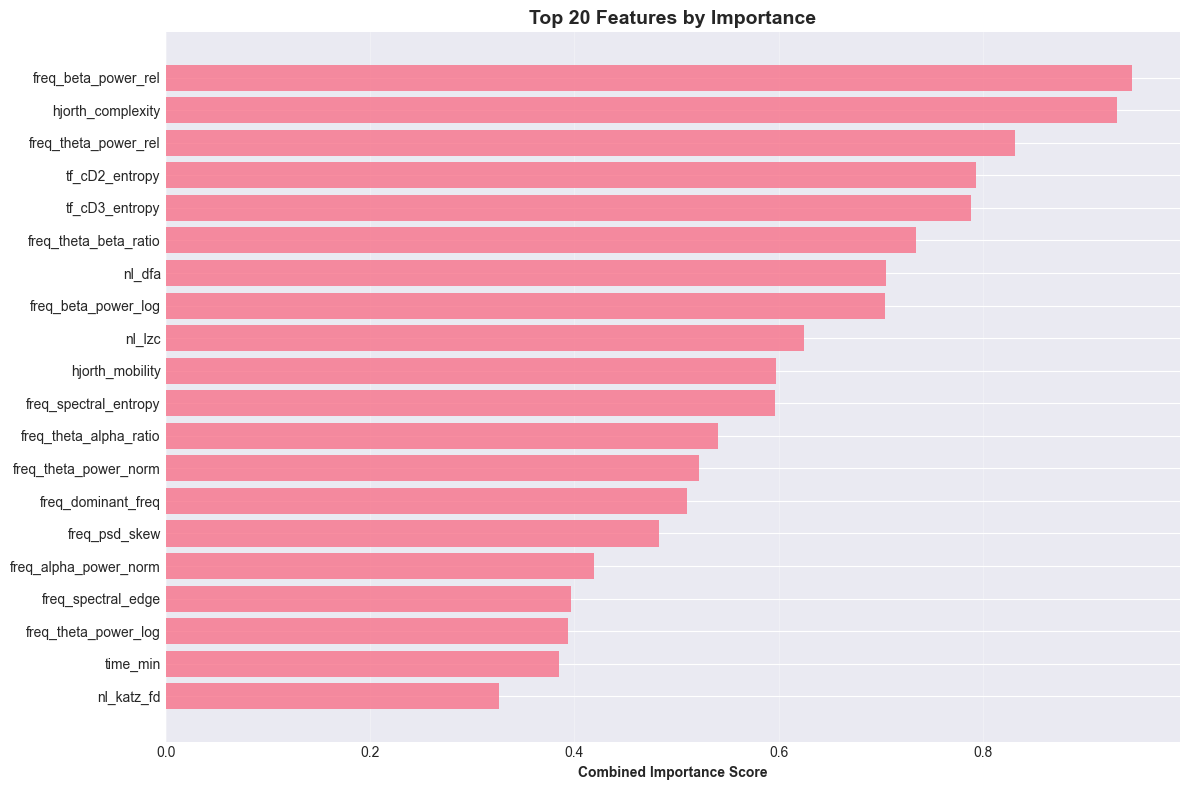

✅ Figure saved: 01_feature_importance.png


In [22]:
# Visualization 1: Feature Importance
fig, ax = plt.subplots(figsize=(12, 8))
top_20 = feature_importance.head(20)
y_pos = np.arange(len(top_20))

ax.barh(y_pos, top_20['combined_score'], alpha=0.8)
ax.set_yticks(y_pos)
ax.set_yticklabels(top_20['feature'])
ax.invert_yaxis()
ax.set_xlabel('Combined Importance Score', fontweight='bold')
ax.set_title('Top 20 Features by Importance', fontweight='bold', fontsize=14)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(FIGURES_DIR / '01_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Figure saved: 01_feature_importance.png")

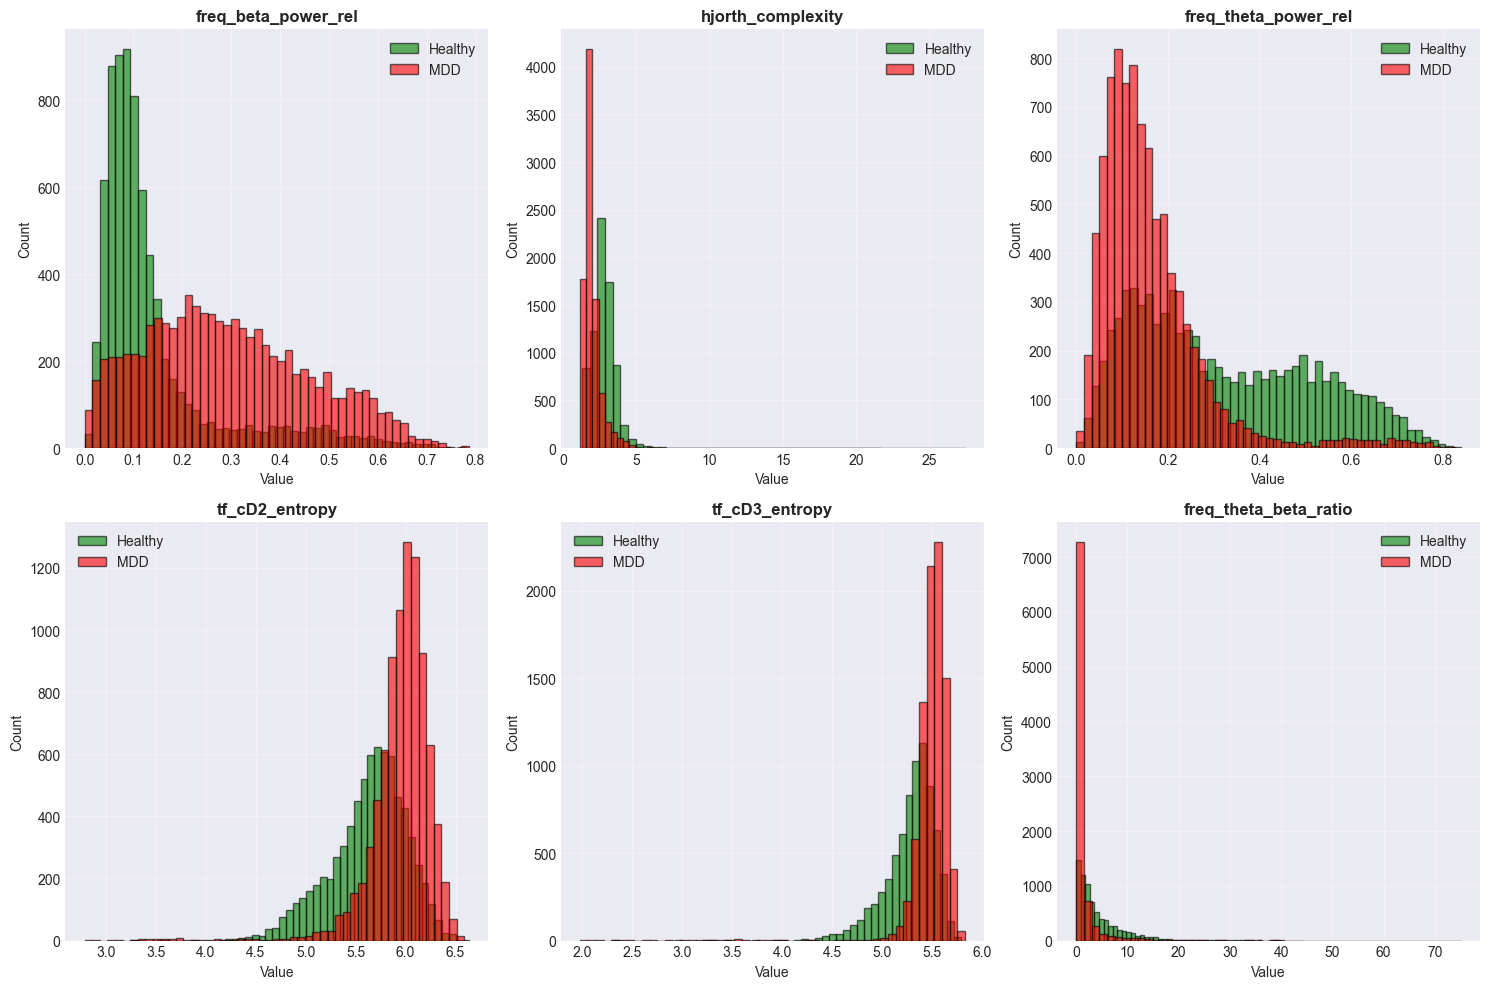

✅ Figure saved: 02_feature_distributions.png


In [23]:
# Visualization 2: Feature Distribution (Top 6 features)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

top_6_features = feature_importance.head(6)['feature'].tolist()

for idx, feat in enumerate(top_6_features):
    healthy_vals = selected_features_df[selected_features_df['group']=='Healthy'][feat]
    mdd_vals = selected_features_df[selected_features_df['group']=='MDD'][feat]
    
    axes[idx].hist(healthy_vals, bins=50, alpha=0.6, label='Healthy', color='green', edgecolor='black')
    axes[idx].hist(mdd_vals, bins=50, alpha=0.6, label='MDD', color='red', edgecolor='black')
    axes[idx].set_title(feat, fontweight='bold')
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Count')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / '02_feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Figure saved: 02_feature_distributions.png")

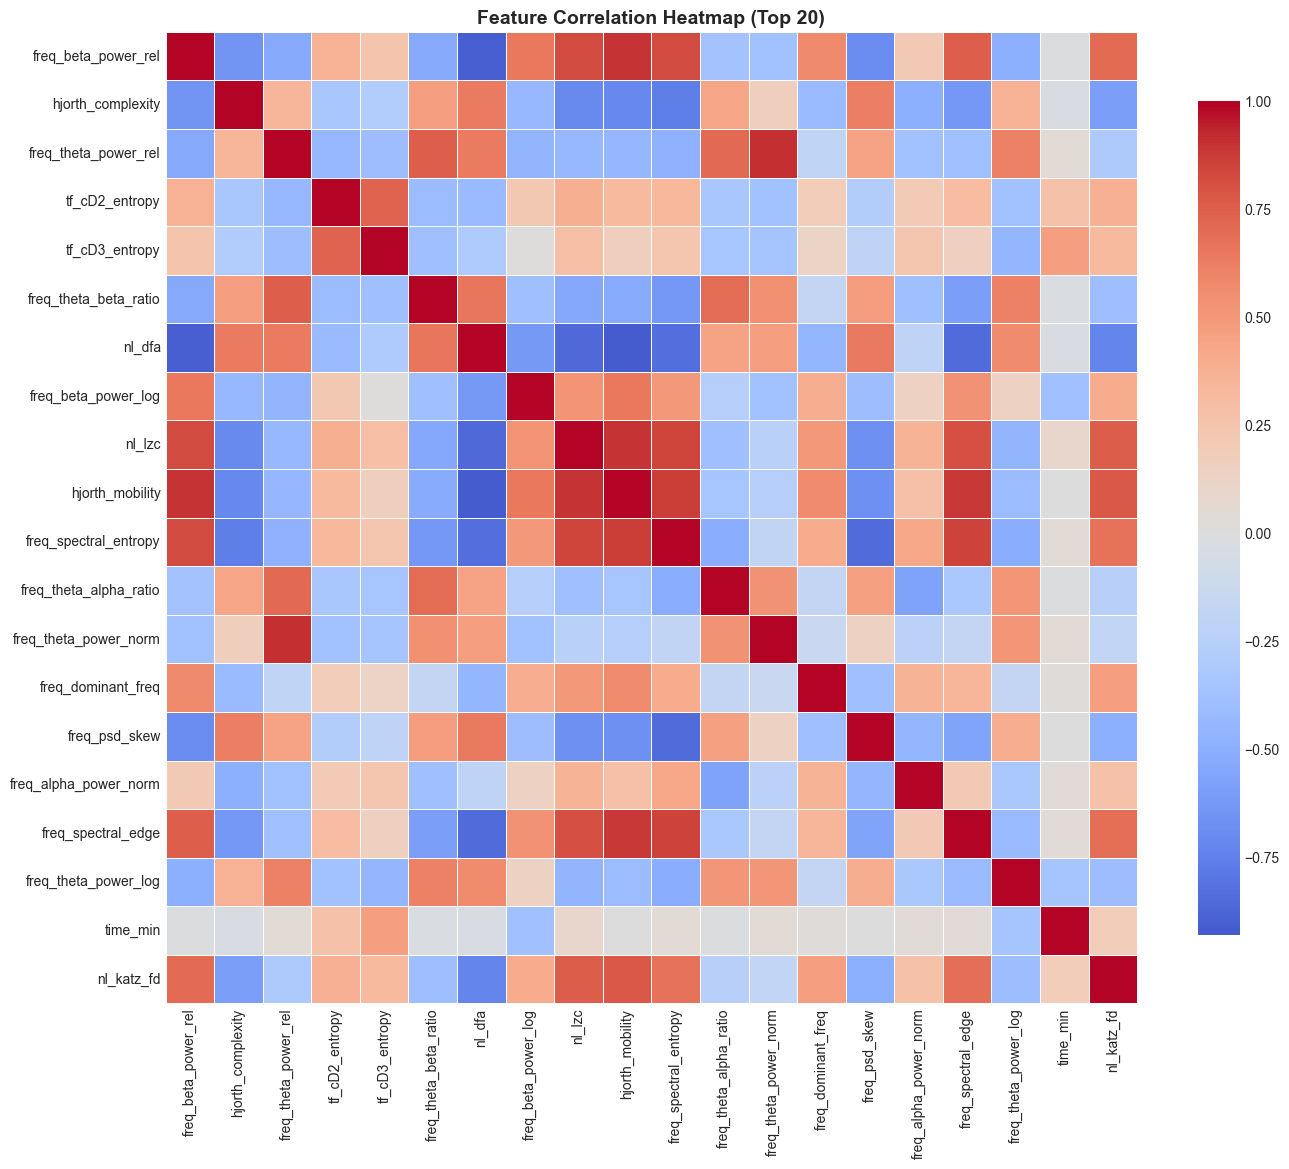

✅ Figure saved: 03_feature_correlation.png


In [24]:
# Visualization 3: Correlation Heatmap (Top 20 features)
top_20_features = feature_importance.head(20)['feature'].tolist()
corr_matrix_top20 = selected_features_df[top_20_features].corr()

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(corr_matrix_top20, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
ax.set_title('Feature Correlation Heatmap (Top 20)', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.savefig(FIGURES_DIR / '03_feature_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Figure saved: 03_feature_correlation.png")

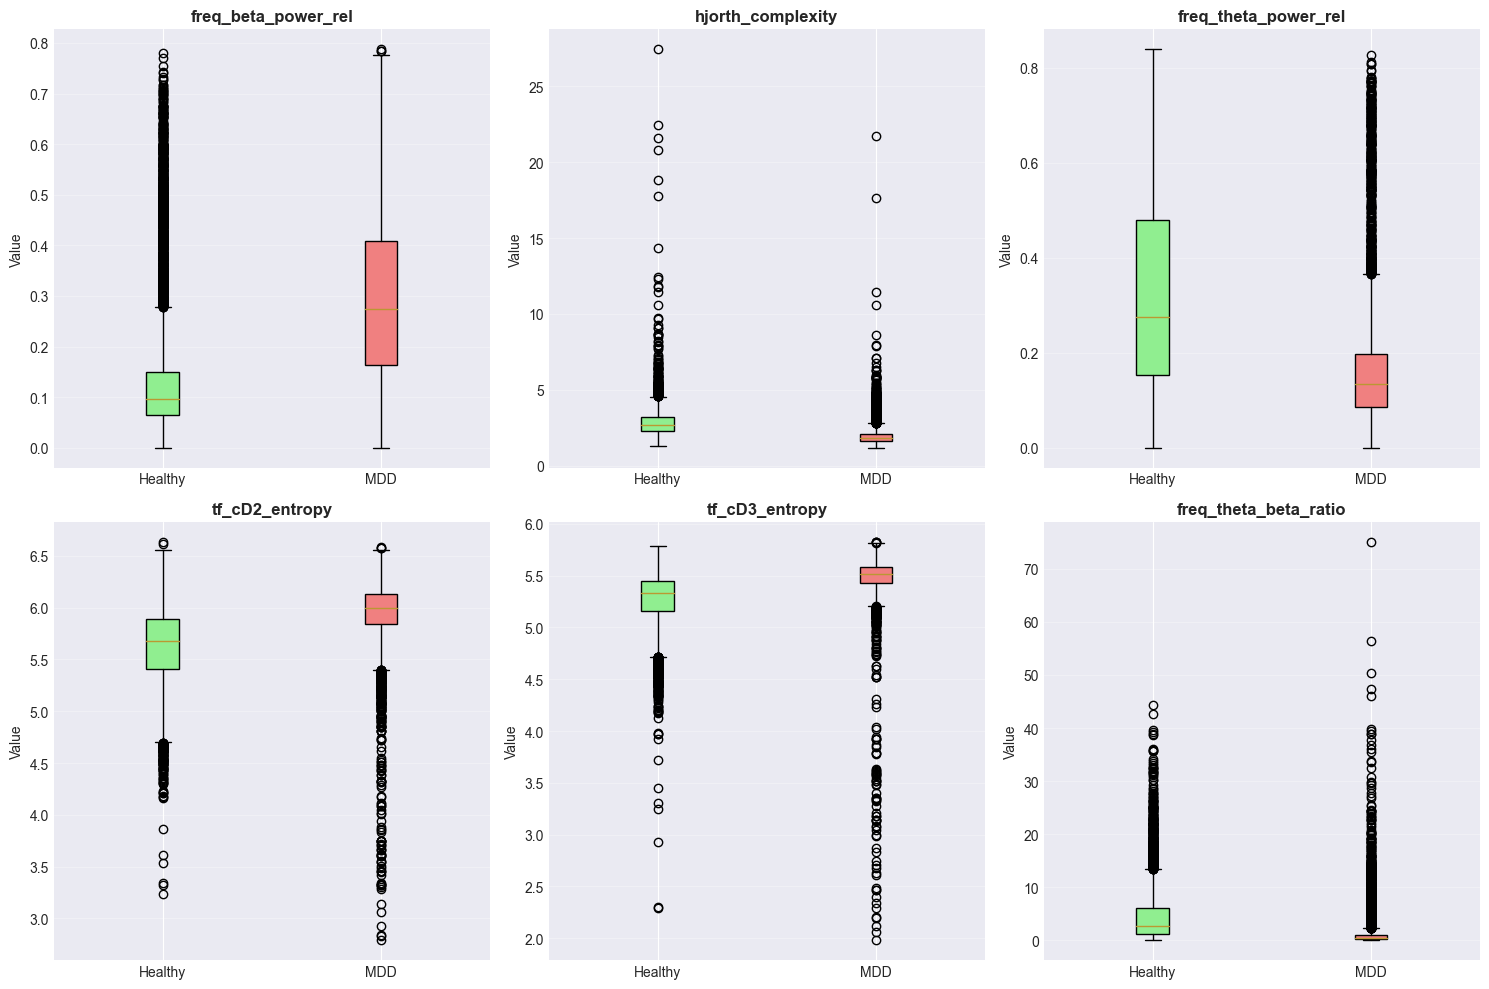

✅ Figure saved: 04_feature_boxplots.png


In [25]:
# Visualization 4: Box Plots (Top 6 features)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, feat in enumerate(top_6_features):
    data = [selected_features_df[selected_features_df['group']=='Healthy'][feat],
            selected_features_df[selected_features_df['group']=='MDD'][feat]]
    
    bp = axes[idx].boxplot(data, labels=['Healthy', 'MDD'], patch_artist=True)
    bp['boxes'][0].set_facecolor('lightgreen')
    bp['boxes'][1].set_facecolor('lightcoral')
    
    axes[idx].set_title(feat, fontweight='bold')
    axes[idx].set_ylabel('Value')
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(FIGURES_DIR / '04_feature_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Figure saved: 04_feature_boxplots.png")

## 12. Save Results

In [26]:
# Save full feature matrix
features_df.to_csv(FEATURES_DIR / 'features_full.csv', index=False)
print(f"✅ Saved: features_full.csv ({features_df.shape})")

# Save selected features
selected_features_df.to_csv(FEATURES_DIR / 'features_selected.csv', index=False)
print(f"✅ Saved: features_selected.csv ({selected_features_df.shape})")

# Save feature importance
feature_importance.to_csv(TABLES_DIR / 'feature_importance.csv', index=False)
print(f"✅ Saved: feature_importance.csv")

# Save effect sizes
effect_sizes_df.to_csv(TABLES_DIR / 'feature_effect_sizes.csv', index=False)
print(f"✅ Saved: feature_effect_sizes.csv")

# Save selected feature names (for ML pipeline)
with open(FEATURES_DIR / 'selected_feature_names.txt', 'w') as f:
    for feat in selected_features:
        f.write(feat + '\n')
print(f"✅ Saved: selected_feature_names.txt")

✅ Saved: features_full.csv ((16336, 146))
✅ Saved: features_selected.csv ((16336, 53))
✅ Saved: feature_importance.csv
✅ Saved: feature_effect_sizes.csv
✅ Saved: selected_feature_names.txt


## 13. Summary Report

In [27]:
print("\n" + "="*100)
print("SPRINT 3 - FEATURE EXTRACTION - FINAL REPORT")
print("="*100)

print("\n🎯 OBJECTIVES ACHIEVED:")
print("  ✅ Loaded 55 cleaned signals (Wavelet method)")
print("  ✅ Segmented into 2-second windows (50% overlap)")
print("  ✅ Extracted 150+ comprehensive features")
print("  ✅ Performed feature selection (variance, correlation, statistical)")
print(f"  ✅ Selected top {TOP_K_FEATURES} most informative features")
print("  ✅ Validated features with effect size analysis")

print("\n📊 DATA STATISTICS:")
print(f"  Total subjects: {len(metadata)}")
print(f"  Total segments: {len(features_df)}")
print(f"    - Healthy: {len(features_df[features_df['group']=='Healthy'])}")
print(f"    - MDD: {len(features_df[features_df['group']=='MDD'])}")
print(f"  Segments per subject (avg): {len(features_df) / len(metadata):.0f}")

print("\n🔢 FEATURE STATISTICS:")
print(f"  Initial features extracted: {len(feature_columns)}")
print(f"  After variance threshold: {len(features_after_var)}")
print(f"  After correlation threshold: {len(features_after_corr)}")
print(f"  Final selected features: {len(selected_features)}")
print(f"  Reduction: {(1 - len(selected_features)/len(feature_columns))*100:.1f}%")

print("\n🏆 TOP 10 FEATURES:")
for idx, row in feature_importance.head(10).iterrows():
    print(f"  {idx+1}. {row['feature']:40s} (score: {row['combined_score']:.4f})")

print("\n💾 DELIVERABLES:")
print(f"  ✅ Full feature matrix: {FEATURES_DIR / 'features_full.csv'}")
print(f"  ✅ Selected features: {FEATURES_DIR / 'features_selected.csv'}")
print(f"  ✅ Feature importance: {TABLES_DIR / 'feature_importance.csv'}")
print(f"  ✅ Effect sizes: {TABLES_DIR / 'feature_effect_sizes.csv'}")
print(f"  ✅ Figures: {FIGURES_DIR} (4 figures)")

print("\n" + "="*100)
print("🎯 NEXT STEPS: Sprint 4 - Machine Learning & Deep Learning")
print("="*100)
print("  1. Load selected feature matrix")
print("  2. Train classical ML models (SVM, RF, XGBoost)")
print("  3. Train Deep Learning models (CNN, LSTM, Hybrid)")
print("  4. Hyperparameter optimization")
print("  5. Model evaluation & comparison")
print("  6. Interpretability analysis (SHAP, feature importance)")
print("="*100)


SPRINT 3 - FEATURE EXTRACTION - FINAL REPORT

🎯 OBJECTIVES ACHIEVED:
  ✅ Loaded 55 cleaned signals (Wavelet method)
  ✅ Segmented into 2-second windows (50% overlap)
  ✅ Extracted 150+ comprehensive features
  ✅ Performed feature selection (variance, correlation, statistical)
  ✅ Selected top 50 most informative features
  ✅ Validated features with effect size analysis

📊 DATA STATISTICS:
  Total subjects: 55
  Total segments: 16336
    - Healthy: 7546
    - MDD: 8790
  Segments per subject (avg): 297

🔢 FEATURE STATISTICS:
  Initial features extracted: 143
  After variance threshold: 124
  After correlation threshold: 70
  Final selected features: 50
  Reduction: 65.0%

🏆 TOP 10 FEATURES:
  50. freq_beta_power_rel                      (score: 0.9457)
  49. hjorth_complexity                        (score: 0.9312)
  48. freq_theta_power_rel                     (score: 0.8318)
  47. tf_cD2_entropy                           (score: 0.7929)
  46. tf_cD3_entropy                           (